# Chat Duell

**Note**: At ~850MB of chat messages this script will use ~5GB of RAM. The calculations are single threaded and will take a few minutes (on an i7@4GHz).

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import datetime
from pytz import timezone
import pytz

In [2]:
#config
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/live'

In [3]:
#chat dataframe
columns = ['datetime', 'username', 'message']
chat = pd.DataFrame({}, columns=columns)

#read chat files
exp = re.compile('\[(.+?)\] <(.+?)> (.+)?')
files = sorted(os.listdir(CHAT_DATA_DIRECTORY))
for filename in files:
    if filename.endswith('.txt'):
        filepath = os.path.join(CHAT_DATA_DIRECTORY, filename)
        dateStr = filename.rstrip('.txt')
        
        #read file
        openfile = open(filepath)
        rawData = openfile.read()
        openfile.close()

        #process each chat message
        splitRawData = rawData.split('\n')
        messages = []
        for line in splitRawData:
            match = exp.match(line)
            if match is not None:
                timeStr = match.group(1)
                datetimeStr = dateStr + ' ' + timeStr
                username = match.group(2)
                message = match.group(3)
                
                messages.append((datetimeStr, username, message))
        
        #create data frame and append data
        chat = chat.append(pd.DataFrame(messages, columns=columns))

#adjust data type
chat['datetime'] = pd.to_datetime(chat['datetime'], format='%Y-%m-%d %H:%M:%S')

#create additional columns
chat['date'] = chat['datetime'].dt.date
chat['time'] = chat['datetime'].dt.time
chat['weekday'] = chat['datetime'].dt.dayofweek

#index
chat = chat.set_index(pd.to_datetime(chat['datetime'], format='%Y-%m-%d %H:%M:%S'))

In [4]:
chat.head()

,datetime,username,message,date,time,weekday
datetime,,,,,,
2015-08-05 02:00:09,2015-08-05 02:00:09,tadloss,!sendeplan,2015-08-05,02:00:09,2
2015-08-05 02:00:09,2015-08-05 02:00:09,moobot,Angaben zum aktuellen Programm findet Ihr: Auf...,2015-08-05,02:00:09,2
2015-08-05 02:00:10,2015-08-05 02:00:10,dersendeplan,@tadloss (01:00) Blue Estate >> (02:30) Darkes...,2015-08-05,02:00:10,2
2015-08-05 02:00:17,2015-08-05 02:00:17,dedalos_stormbring,"@Gunvolf, Brav. Kappa",2015-08-05,02:00:17,2
2015-08-05 02:00:18,2015-08-05 02:00:18,unclesreefermadness,ist da nicht schmatzen gäng und ein kompliment,2015-08-05,02:00:18,2


In [5]:
chat.tail()

,datetime,username,message,date,time,weekday
datetime,,,,,,
2016-09-21 02:59:14,2016-09-21 02:59:14,niunOne,😖,2016-09-21,02:59:14,2
2016-09-21 02:59:21,2016-09-21 02:59:21,forearth,😯😦😣😠😈 Niemals! Gesichtskuchen,2016-09-21,02:59:21,2
2016-09-21 02:59:37,2016-09-21 02:59:37,SkyStraver,"@DMC05 bitte nicht q,q Du hast soviel mehr zu ...",2016-09-21,02:59:37,2
2016-09-21 02:59:57,2016-09-21 02:59:57,HipHopGuru,Den hat er Jahrelang verkauft,2016-09-21,02:59:57,2
2016-09-21 02:59:59,2016-09-21 02:59:59,niunOne,@DMC05 du machst immer so andeutungen und dann...,2016-09-21,02:59:59,2


In [6]:
#live dataframe
columns = ['datetime', 'viewers']
live = pd.DataFrame({}, columns=columns)

#read live files
liveTmp = []
timezoneLocal = timezone('Europe/Berlin')
files = sorted(os.listdir(LIVE_DATA_DIRECTORY))
for filename in files:
    if filename.endswith('.csv'):
        filepath = os.path.join(LIVE_DATA_DIRECTORY, filename)
        
        #read file
        openfile = open(filepath)
        rawData = openfile.read()
        openfile.close()
        
        #process each datapoint
        splitRawData = rawData.split('\n')
        datapoints = []
        for line in splitRawData:
            split = line.split(',')
            if len(split) == 2:
                timestamp = split[0]
                viewers = int(split[1])
                datetimeObj = datetime.datetime.fromtimestamp(int(timestamp))
                datapoints.append((datetimeObj, viewers))
        
        live = live.append(pd.DataFrame(datapoints, columns=columns))

#sort data
live = live.sort_values(['datetime'], ascending=[True])

#index
live = live.set_index(live['datetime'])

In [7]:
live.head()

,datetime,viewers
datetime,,
2015-01-15 18:37:02,2015-01-15 18:37:02,757.0
2015-01-15 18:37:47,2015-01-15 18:37:47,757.0
2015-01-15 18:37:50,2015-01-15 18:37:50,757.0
2015-01-15 18:37:52,2015-01-15 18:37:52,757.0
2015-01-15 18:37:54,2015-01-15 18:37:54,757.0


In [8]:
live.tail()

,datetime,viewers
datetime,,
2016-09-20 21:56:03,2016-09-20 21:56:03,6083.0
2016-09-20 21:57:02,2016-09-20 21:57:02,6096.0
2016-09-20 21:58:03,2016-09-20 21:58:03,6130.0
2016-09-20 21:59:02,2016-09-20 21:59:02,6176.0
2016-09-20 22:00:02,2016-09-20 22:00:02,6242.0


In [9]:
#prepare chat message data
chatFiltered = chat

#filter messages by time
start = datetime.time(20, 15, 0)
end = datetime.time(22, 0, 0)
chatFiltered = chatFiltered.between_time(start, end)

#filter messages containing `!cd`
chatFiltered = chatFiltered[chatFiltered['message'].str.contains('!cd')]

#filter meassages by weekday
chatFiltered = chatFiltered[chatFiltered['weekday'] == 1]

#group messages by date
chatGrouped = chatFiltered.groupby('date')

#filter groups by count threshold
chatGrouped = chatGrouped.filter(lambda group: len(group) > 2000)

#group messages by date
chatGrouped = chatGrouped.groupby('date')

#count (unique) users
chatParticipants = chatGrouped.username.nunique()
chatParticipants

date
2015-12-01     8277
2015-12-08     7981
2015-12-15     5696
2015-12-22     6050
2016-01-12     7278
2016-01-19     6756
2016-02-02     6040
2016-02-09    11991
2016-02-16     5736
2016-02-23     6108
2016-03-01    11267
2016-03-08     5833
2016-03-15     5605
2016-06-28     4468
2016-07-12     3519
2016-07-19     2750
2016-07-26     3656
2016-08-02     3054
2016-08-09     3010
2016-08-23     3019
2016-08-30     2745
2016-09-13     2385
2016-09-20     1928
Name: username, dtype: int64

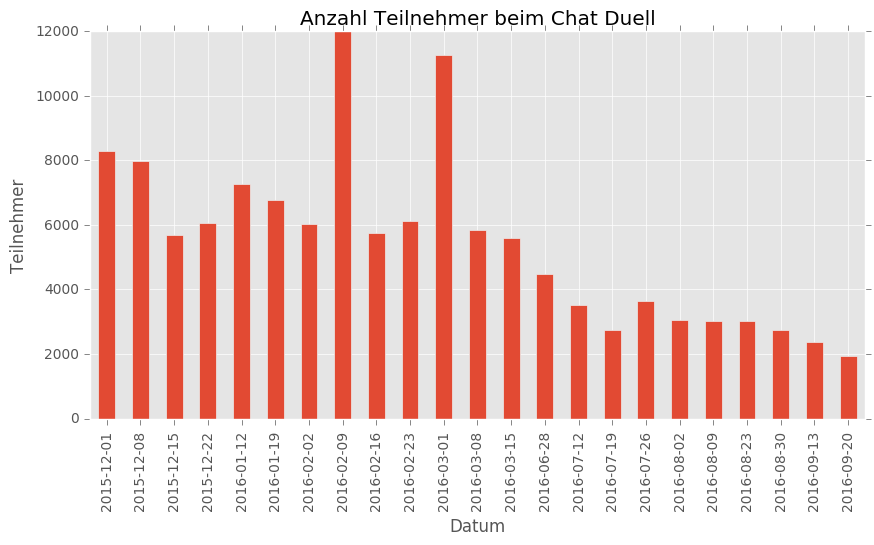

In [10]:
plot = chatParticipants.plot(kind='bar', figsize=(10, 5), title='Anzahl Teilnehmer beim Chat Duell')
plot.set_xlabel('Datum')
plot.set_ylabel('Teilnehmer')
plot

In [11]:
#prepare live viewer data
meanViewersTmp = []
for date, count in chatGrouped.size().iteritems():
    start = datetime.datetime.combine(date, datetime.time(20, 15, 0))
    end = datetime.datetime.combine(date, datetime.time(22, 0, 0))
    viewers = live.loc[start : end]['viewers']
    meanViewersTmp.append((date, int(viewers.mean())))

#mean viewers dataframe
columns = ['date', 'viewers']
meanViewers = pd.DataFrame(meanViewersTmp, columns=columns)

#index
meanViewers = meanViewers.set_index(meanViewers['date'])

meanViewers

,date,viewers
date,,
2015-12-01,2015-12-01,19607
2015-12-08,2015-12-08,20263
2015-12-15,2015-12-15,14203
2015-12-22,2015-12-22,15241
2016-01-12,2016-01-12,18344
2016-01-19,2016-01-19,17279
2016-02-02,2016-02-02,15976
2016-02-09,2016-02-09,36257
2016-02-16,2016-02-16,16178


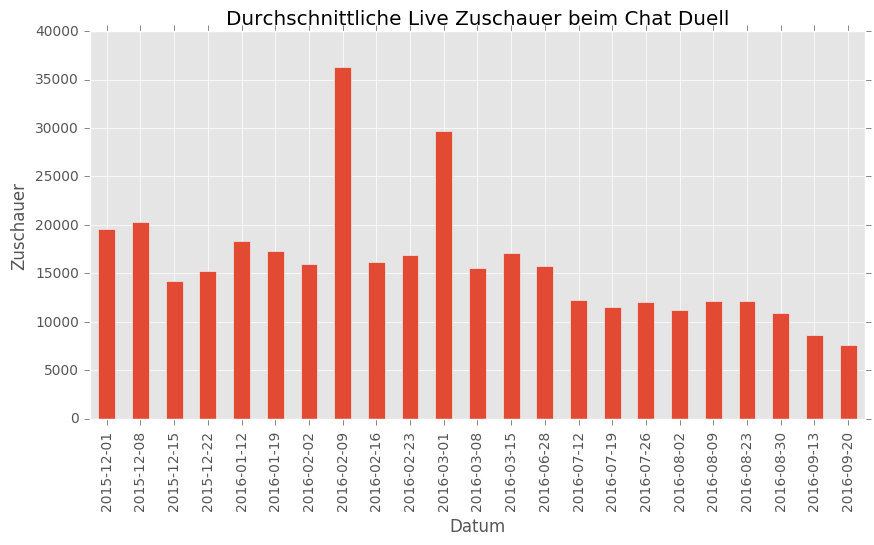

In [12]:
plot = meanViewers.plot(kind='bar', figsize=(10, 5), legend=False, title='Durchschnittliche Live Zuschauer beim Chat Duell')
plot.set_xlabel('Datum')
plot.set_ylabel('Zuschauer')
plot